In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy as cart
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib import gridspec

import pandas as pd
import h3
from h3.unstable import vect  # used for hexgrid vectorization

import xarray as xr

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
class countGrid:
    """
    'Reference object' for creating transition matrices. This acts as a sort of template
    to form transition matrices with, as well as a dictionary to convert between integer
    indices and hex positions.

    To do [priority]:
     - Allow for shrinking the matrix based on empty elements [low]
     - Differentiate between 2D and 3D [low]
    """

    def __init__(self, polygon, level_bounds=[0, np.inf], h3_res=3):
        """
        Initialize the grid.

        Parameters
        ----------
        polygon : dict
            Polygon defining the region of interest.
        level_bounds : list
            List of floats defining the vertical level boundaries of the grid.
        h3_res : int
            Resolution of the H3 grid.
        """
        # Polygon needs to be specified in lat-lon pairs, NOT lon-lat!
        self.polygon = polygon
        self.level_bounds = level_bounds
        self.h3_res = h3_res
        self.hexagons = list(h3.polyfill(polygon, h3_res))
        self.hexint = np.array([int(a, 16) for a in self.hexagons])
        self.n_levels = len(level_bounds) - 1
        self.levels = np.arange(self.n_levels)
        self.n_hex = len(self.hexagons)
        self.n = self.n_levels * self.n_hex
        self.edges = dict()
        self.matidx = np.arange(0, self.n, dtype=np.uint(64))

        # These series can be used to quickly convert between hexagon and matrix index
        self.map_to_mat_nodepth = pd.Series(index=self.hexagons, data=self.matidx[:self.n_hex])
        self.map_from_mat_depth = pd.Series(index=self.matidx, data=np.repeat(self.levels, self.n_hex))
        self.map_from_mat_hex = pd.Series(index=self.matidx, data=np.tile(self.hexagons, self.n_levels))

    def compute_centroids(self):
        self.centroids = [h3.h3_to_geo(hex) for hex in self.hexagons]
        self.cen_lats = [c[0] for c in self.centroids]
        self.cen_lons = [c[1] for c in self.centroids]

    def info(self):
        print(f"Number of hexagons in the region with grid resolution {self.h3_res}:", len(self.hexagons))
        print(f"Levels: {self.n_levels}")
        print(f"Total number of bins:", self.n)

    def count_2d(self, lon, lat):
        """
        Count particles in a 2D grid.

        Parameters
        ----------
        lon : np.array
            Array of longitudes
        lat : np.array
            Array of latitudes

        Returns
        -------
        np.array
            Array of counts per bin.
        """

        interpolated_hexes_as_int = vect.geo_to_h3(lat, lon, self.h3_res)
        count = np.zeros(self.n_hex, dtype=np.uint(64))

        counted_unique_int, counted_unique_int_occurences = np.unique(interpolated_hexes_as_int, return_counts=True)
        counted_unique_hexes = [hex(hexagon)[2:] for hexagon in counted_unique_int]
        self.miscount = 0

        for hexagon_idx, hexagon in enumerate(counted_unique_hexes):
            try:
                count_idx = self.hexagons.index(hexagon)
                count[count_idx] = counted_unique_int_occurences[hexagon_idx]
            except ValueError:
                pass

        if self.miscount > 0:
            print(f"{self.miscount} particles were not counted because they were outside the region of interest.")
        return count

    def count_3d(self, lat, lon, depth):
        pass

    def map_to_mat(self):
        pass

    def map_from_mat(self):
        pass

    def plot_my_centroids(self, domain):
        centroids = [h3.h3_to_geo(hex) for hex in self.hexagons]
        cen_lats = [c[0] for c in centroids]
        cen_lons = [c[1] for c in centroids]

        fig = plt.figure()
        ax = plt.axes(projection=cart.crs.PlateCarree())
        ax.scatter(cen_lons, cen_lats, s=0.3, c='r', transform=cart.crs.PlateCarree())
        ax.coastlines()
        ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
        plt.show()

In [3]:
def pcolorhex(ax,
              hexagons,
              colors=None,
              draw_edges=True,
              fill_polygons=True,
              transform=cart.crs.PlateCarree(),
              **kwargs):
    """
    Draw a collection of hexagons colored by a value. Based on a script from Mikael.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw to
    hexes : list
        A list of `h3` hexagons (i.e. related to tools.countGrid.hexagons)
    colors : list, optional
        A list of colors to use for each hexagon, by default None
    draw_edges : bool, optional
        Whether to draw the edges of the hexagons, by default True
    fill_polygons : bool, optional
        Whether to fill the hexagons with color, by default True
    **kwargs
        Additional keyword arguments passed to `matplotlib.pyplot.fill`

    Returns
    -------
    None
        This function does not return anything, but it does draw to the axes
        that are passed in.
    """
    for i1, hex_ in enumerate(hexagons):
        # get latitude and longitude coordinates of hexagon
        lat_long_coords = np.array(h3.h3_to_geo_boundary(str(hex_)))
        x = lat_long_coords[:, 1]
        y = lat_long_coords[:, 0]

        # ensure that all longitude values are between 0 and 360
        x_hexagon = np.append(x, x[0])
        y_hexagon = np.append(y, y[0])
        if x_hexagon.max() - x_hexagon.min() > 25:
            x_hexagon[x_hexagon < 0] += 360

        # draw edges
        if draw_edges:
            ax.plot(x_hexagon, y_hexagon, 'k-', transform=transform, linewidth=.2)

        # fill polygons
        if fill_polygons:
            ax.fill(x_hexagon, y_hexagon, color=colors[i1], transform=transform, **kwargs)


def get_colornorm(vmin=None, vmax=None, center=None, linthresh=None, base=None):
    """"
    Return a normalizer

    Parameters
    ----------
    vmin : float (default=None)
        Minimum value of the data range
    vmax : float (default=None)
        Maximum value of the data range
    center : float (default=None)
        Center value for a two-slope normalization
    linthresh : float (default=None)
        Threshold for a symmetrical log normalization
    base : float (default=None)
        Base for a symmetrical log normalization

    Returns
    -------
    norm : matplotlib.colors.Normalize object
        A normalizer object
    """
    if type(base) is not type(None) and type(linthresh) is type(None):
        norm = colors.LogNorm(vmin=None, vmax=None)
    elif type(linthresh) is not type(None) and type(base) is not type(None):
        norm = colors.SymLogNorm(linthresh=linthresh, base=base, vmin=None, vmax=None)
    elif center:
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
    else:
        norm = colors.Normalize(vmin, vmax)
    return norm


def get_colors(inp, colormap, vmin=None, vmax=None, center=None, linthresh=None, base=0):
    """"
    Based on input data, minimum and maximum values, and a colormap, return color values

    Parameters
    ----------
    inp : array-like
        Input data
    colormap : matplotlib.colors.Colormap object
        Colormap to use
    vmin : float (default=None)
        Minimum value of the data range
    vmax : float (default=None)
        Maximum value of the data range
    center : float (default=None)
        Center value for a two-slope normalization
    linthresh : float (default=None)
        Threshold for a symmetrical log normalization
    base : float (default=None)
        Base for a symmetrical log normalization

    Returns
    -------
    colors : array-like
        Array of color values
    """
    norm = get_colornorm(vmin, vmax, center, linthresh, base)
    return colormap(norm(inp))


def plot_hex_hist(counts, grid, title=None, maxnorm=None, extent=(-85, -30, 20, 50), label='Particles per bin', ax=None, return_fig=False):
    """
    Plot a histogram of particle counts in a hexagonal grid

    Parameters
    ----------
    counts : array-like
        Array of particle counts. Should be the same length as the grid
    grid : tool.countGrid object
        Grid object containing the hexagonal grid
    title : str, optional
        Title of the plot, by default None
    maxnorm : int, optional
        Maximum value of the colorbar, by default None  
    label : str, optional
        Label of the colorbar, by default 'Particles per bin'
    extent : tuple, optional
        Extent of the map, by default (-85, -30, 20, 50)
    ax : matplotlib.axes.Axes, optional
        Axes to plot to, by default None
    return_fig : bool, optional
        Whether to return the figure, by default False
    """
    if not maxnorm:
        maxnorm = counts.max()

    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': cart.crs.PlateCarree()})
    else:
        fig = ax.figure
        # ax.set_projection(cart.crs.PlateCarree())

    # Creating the histogram
    pcolorhex(ax, grid.hexagons, get_colors(counts, plt.cm.viridis, 0,
                                            maxnorm), draw_edges=False, alpha=1., label=' concentration')

    # Cartopy stuff
    ax.coastlines()
    ax.gridlines(draw_labels=["left", "bottom"])
    ax.set_extent(extent, crs=cart.crs.PlateCarree())

    # Colorbar
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
    cmap = plt.cm.viridis
    cmap.set_bad('w')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=maxnorm))
    cbar = plt.colorbar(sm, cax=ax_cb, label=label)
    fig.add_axes(ax_cb)

    # Title
    if title:
        ax.set_title(title)

    plt.tight_layout()

    if return_fig:
        return fig


def plot_hex_hist_3d(lon,
                     lat,
                     depth,
                     horiz_grid,
                     figsize=(10, 6),
                     extent=(-80, -30, 10, 60),
                     depths=(0, 600)):
    """
    Plot a histogram of particle counts in a hexagonal grid, including a depth view along longitude and latitude.

    Parameters
    ----------
    lon : np.array
        Array of longitudes
    lat : np.array
        Array of latitudes
    depth : np.array
        Array of depths
    horiz_grid : tool.countGrid object
        Grid object containing the hexagonal grid
    figsize : tuple, optional
        Figure size, by default (10, 6)
    extent : tuple, optional
        Extent of the map, by default (-80, -30, 10, 60)
    depths : tuple, optional
        Extent of the depth view, by default (0, 600)
    """

    hexCount = horiz_grid.count_2d(lon, lat)

    maxnorm = hexCount.max()
    colors = get_colors(hexCount, colormap=plt.cm.viridis, vmin=0, vmax=maxnorm)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 4,
                           width_ratios=[2, 0.7, 0.05, 0.1],
                           height_ratios=[2, 1])

    # Create a GeoAxes in the left part of the plot
    ax = plt.subplot(gs[0, 0], projection=cart.crs.PlateCarree())
    pcolorhex(ax, horiz_grid.hexagons, colors, draw_edges=False, alpha=1.)
    ax.add_feature(cart.feature.LAND, edgecolor='black', zorder=100)
    ax.set_extent(extent, crs=cart.crs.PlateCarree())
    cmap = plt.cm.viridis
    cmap.set_bad('w')

    normalizer = plt.Normalize(vmin=0, vmax=maxnorm)

    # Create a regular axes in the right part of the plot, sharing its y-axis
    ax_depth_lat = plt.subplot(gs[0, 1], sharey=ax)
    depht_lat_hexbin = ax_depth_lat.hexbin(depth, lat,
                                           extent=(depths[0], depths[1], extent[2], extent[3]),
                                           cmap=plt.cm.viridis,
                                           norm=normalizer,
                                           mincnt=1,
                                           gridsize=(10, 30))
    ax_depth_lat.tick_params(left=False, labelleft=False, right=True, labelright=True)  # Hide y-axis labels
    ax_depth_lat.yaxis.set_major_formatter(cart.mpl.gridliner.LATITUDE_FORMATTER)  # Set x-axis labels to degree format
    ax_depth_lat.set_xlabel('Depth (m)')
    ax_depth_lat.xaxis.set_ticks_position('top')
    ax_depth_lat.xaxis.set_label_position('top')

    # Create a regular axes in the bottom part of the plot, sharing its x-axis
    ax_lon_depth = plt.subplot(gs[1, 0], sharex=ax)
    lon_depth_hexbin = ax_lon_depth.hexbin(lon, depth,
                                           extent=(extent[0], extent[1], depths[0], depths[1]),
                                           cmap=plt.cm.viridis,
                                           norm=normalizer,
                                           mincnt=1,
                                           gridsize=(30, 10))
    ax_lon_depth.tick_params(top=False, labeltop=False)  # Hide x-axis labels
    ax_lon_depth.xaxis.set_major_formatter(cart.mpl.gridliner.LONGITUDE_FORMATTER)  # Set y-axis labels to degree format
    ax_lon_depth.invert_yaxis()
    ax_lon_depth.set_ylabel('Depth (m)')

    gridliner = ax.gridlines(draw_labels=True, xlocs=ax_depth_lat.xaxis.get_major_locator(),
                             ylocs=ax_lon_depth.yaxis.get_major_locator())
    gridliner.bottom_labels = False
    gridliner.right_labels = False

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalizer)
    cbar_lon_lat = plt.colorbar(sm, cax=plt.subplot(gs[:, 3]), orientation='vertical')
    cbar_lon_lat.set_label('Particles per bin')

    return fig
    # plt.show()

In [4]:
pset_23 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

In [5]:
pset_23

<xarray.Dataset> Size: 764MB
Dimensions:     (trajectory: 65536, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 524kB 0 1 2 3 4 ... 65532 65533 65534 65535
Data variables:
    lat         (trajectory, obs) float64 191MB dask.array<chunksize=(65536, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 191MB dask.array<chunksize=(65536, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 191MB dask.array<chunksize=(65536, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 191MB dask.array<chunksize=(65536, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [6]:
# NA_domain = {"type": "Polygon",
#             "coordinates": [
#           [[
#               37.15204224208735,
#               -74.8779314136824
#             ],
#             [
#               32.699554628354065,
#               -74.8779314136824
#             ],
#             [
#               32.699554628354065,
#               -64.61191662086819
#             ],
#             [
#               37.15204224208735,
#               -64.61191662086819
#             ],
#             [
#               37.15204224208735,
#               -74.8779314136824
#             ]
#           ]
#         ],
#       }

In [7]:
NA_domain = {"type": "Polygon",
             "coordinates": [
                 [[26.1, -80.3],
                  [34.0, -84.4],
                     [24.0, -103.8],
                     [17.1, -93.1],
                     [8.9, -79.6],
                     [5.6, -62.4],
                     [6.0, -7.7],
                     [14.1, -15.9],
                     [24.9, -13.6],
                     [54.7, -8.2],
                     [57.3, -46.6],
                     [39.9, -77.4],
                     [35.7, -76.9],
                     [32.1, -82.1],
                     [28.1, -83.3]]
             ]}


In [8]:
NA_domain

{'type': 'Polygon',
 'coordinates': [[[26.1, -80.3],
   [34.0, -84.4],
   [24.0, -103.8],
   [17.1, -93.1],
   [8.9, -79.6],
   [5.6, -62.4],
   [6.0, -7.7],
   [14.1, -15.9],
   [24.9, -13.6],
   [54.7, -8.2],
   [57.3, -46.6],
   [39.9, -77.4],
   [35.7, -76.9],
   [32.1, -82.1],
   [28.1, -83.3]]]}

In [10]:
xxx = h3.polyfill(NA_domain, 3)

In [11]:
type(xxx)

set

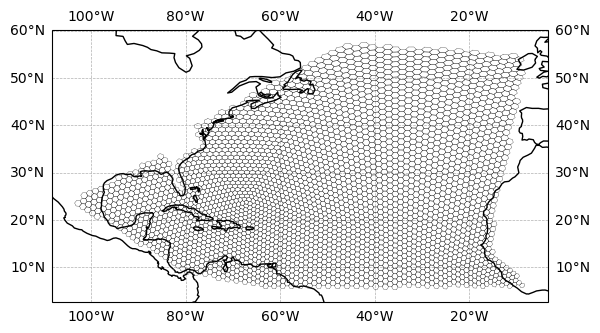

In [10]:
# Plot NA_domain on a map
fig = plt.figure()
ax = plt.axes(projection=cart.crs.PlateCarree())
# ax.set_extent([-100, 0, 0, 70], crs=cart.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
pcolorhex(ax, h3.polyfill(NA_domain, 3), colors='r', draw_edges=True, fill_polygons=False)
# pcolorhex(ax, h3.polyfill(NA_domain, 4), colors='b', draw_edges=True, fill_polygons=False)

In [11]:
timeframe = 300
plons = pset_23.lon[:, timeframe]
plats = pset_23.lat[:, timeframe]

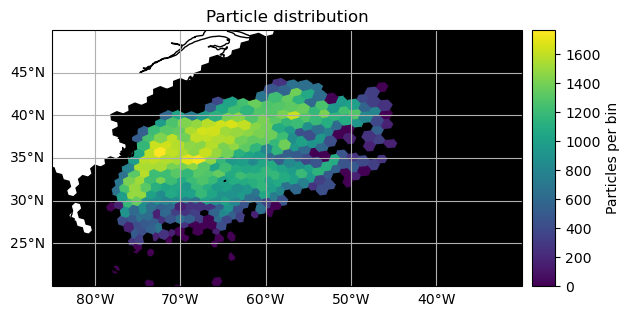

In [12]:
hexHistCount = countGrid(NA_domain, h3_res=3)
initCount = hexHistCount.count_2d(plons, plats)
fig = plot_hex_hist(initCount, hexHistCount, title='Particle distribution')



In [47]:
density = initCount/np.sum(initCount)

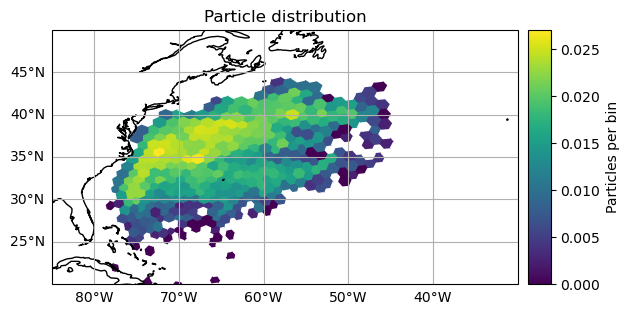

In [48]:
plot_hex_hist(density, hexHistCount, title='Particle distribution')

(array([2.684e+03, 4.200e+01, 1.000e+01, 1.000e+01, 8.000e+00, 1.000e+01,
        1.300e+01, 1.100e+01, 8.000e+00, 1.100e+01, 9.000e+00, 5.000e+00,
        5.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 8.000e+00, 4.000e+00,
        3.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        0.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+0

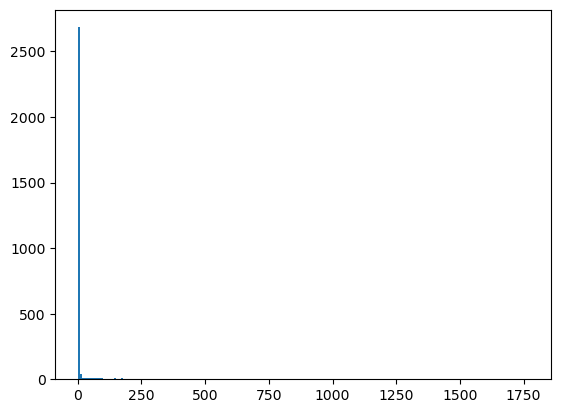

In [49]:
plt.hist(initCount, bins=200)